**PASCAL VOC 2007 dataset**; seems like a good dataset to work because its versatile and im more familarized with it thanks to the Lab9 we previously worked on.

So first lets check if we have installed all needed libraries and then import them to our empty notebook and load the PASCAL VOC 2007 dataset.

In [ ]:
%pip install tensorflow tensorflow-hub tensorflow-datasets matplotlib


After installing we need to import the libraries

In [ ]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
import requests
from io import BytesIO
import os
from PIL import Image

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.17.1
TensorFlow Hub version: 0.16.1


Next is Downloading the PASCAL VOC 2007 dataset.
In the code to dowload a small portion of PASCAL data, are some variables that a worthy to note.

We define a function with ***load_data*** to load the COCO dataset.

***tfds.load*** = is a function that downloads and prepares the dataset.

We use only 1% of the training data to keep the demonstration manageable.

***shuffle_files***=True ensures that we get a random sample of the dataset.

***with_info***=True returns additional information about the dataset, which we'll use later.

REMEMBER** THERE IS AROUND 20 OBJECT CLASS RANGING FROM PEOPLE AND ANIMALS TO VEHICLES AND INDOOR ITEMS. HOWEVER BECAUSE WE ARE EXPORTING SUCH A SMALL PART OF THE DATASET THE MODEL MIGHT NOT BE ACCURATE

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load a smaller dataset
def load_data(split='train'):
    dataset, info = tfds.load('voc/2007', split=split, shuffle_files=True, with_info=True)
    return dataset, info

# Load the train dataset and extract info
train_dataset, train_info = load_data('train[:11%]')

# Load the validation dataset
validation_dataset, validation_info = load_data('validation[:10%]')

# Get class names
class_names = train_info.features["objects"]["label"].names  # Changed from ds_info to train_info
print("Class names:", class_names)



Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


### on the clean_dataset we increased it to 512, so that the model we are using can handle the higher resolution inputs.

In [ ]:
import os
import numpy as np
from PIL import Image

# Function to normalize image sizes and clean dataset
def normalize_images(image_path, target_size=(512, 512)):
    """Resize images to a target size."""
    image = Image.open(image_path).convert("RGB")  # Ensure all images are RGB
    image = image.resize(target_size)
    return np.array(image)

def clean_dataset(dataset_path, target_size=(300, 300)):
    """
    Load and clean dataset by normalizing image sizes.
    Ignores non-image files or corrupted files.
    """
    cleaned_data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                image = normalize_images(image_path, target_size)
                cleaned_data.append(image)
            except Exception as e:
                print(f"Error processing {file}: {e}")  # Log errors without stopping
    return np.array(cleaned_data)

In [ ]:
# Specify the dataset path
dataset_path = 'voc/2007'

# Clean and normalize images
cleaned_images = clean_dataset(dataset_path)

# Print how many images were successfully processed
print(f"Cleaned {len(cleaned_images)} images")


Cleaned 0 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,          # Normalize pixel values to [0, 1]
    rotation_range=20,           # Rotate images up to 20 degrees
    width_shift_range=0.1,       # Shift images horizontally up to 10%
    height_shift_range=0.1,      # Shift images vertically up to 10%
    horizontal_flip=True,        # Flip images horizontally
    zoom_range=0.1,              # Random zoom up to 10%
    shear_range=0.1,             # Apply shear transformation with 10% max angle
    channel_shift_range=10.0     # Shift image color channels
)

# Apply augmentation to the cleaned images
def augment_data(cleaned_images):
    """
    Augment the cleaned images using the defined augmentation pipeline.
    """
    augmented_images = []
    for image in cleaned_images:
        # Expand dimensions to mimic a batch
        image_batch = np.expand_dims(image, axis=0)
        # Apply augmentation
        for augmented_image in data_gen.flow(image_batch, batch_size=1):
            augmented_images.append(augmented_image[0])  # Add augmented image
            break  # Ensure only one augmented version per image
    return np.array(augmented_images)

Important things to note are in line 1, it takes two parameters "dataset" which  gives us example images from the dataset with groundtruth boxes and "n=3" asking us how many examples we want.

Line 2 iterates takes "n" number of examples and iterates to display the example image with their corresponding bounding boxes using .take(). Example is a dictionary containing keys with the "image" for the image data and "object" being the bounding boxes.
- it displays the images using plt.imshow(image), it configures the picture size with plt.figure, and the title is displays with plt.title.
- the for loop box in example["objects"]["bbox] is going to iterate through the
bbox in the objects directory. Each bounding box is expected to be a list or array with coordinates [ymin, xmin, ymax, xmax]. The coordinates are transformed into pixel coordinates using image.shape[1] for width and image.shape[0] for height.
- the (patches.Rectangle) creates a rectangle to correspond with the box:
- (xmin * image.shape[1], ymin * image.shape[0]) calculates the top-left corner,
- (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0] calculates the width and height of the rectangle

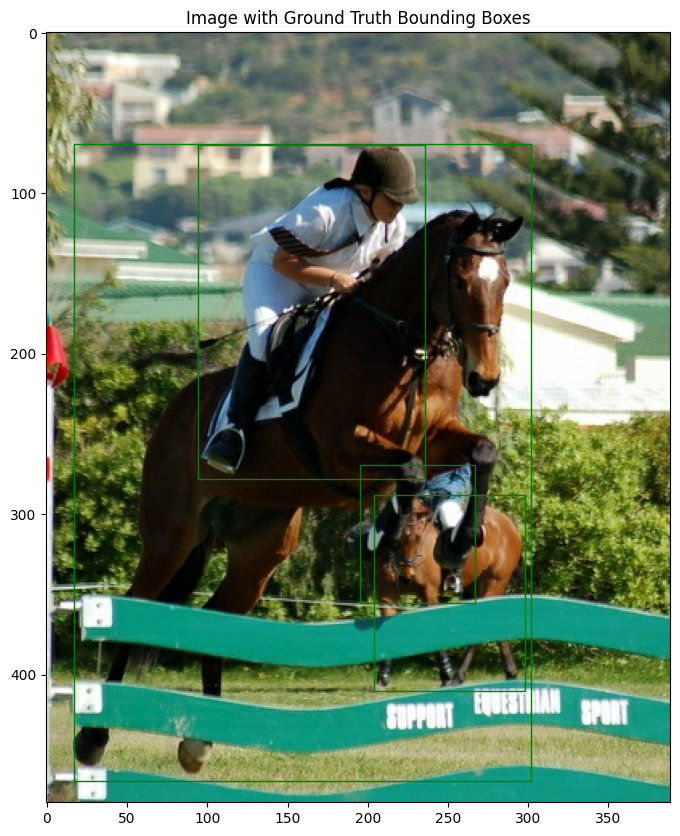

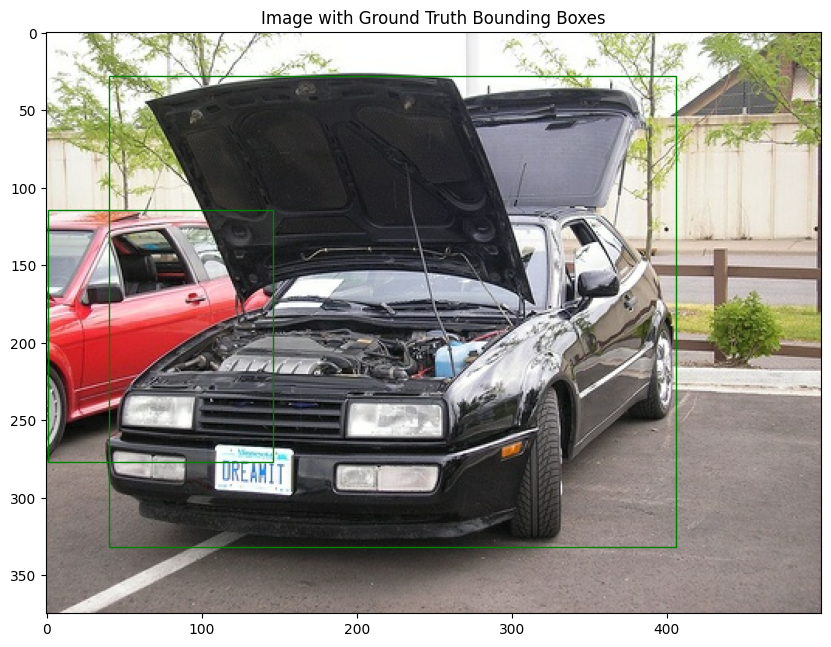

In [ ]:
def display_examples(dataset, n=2):  # Display 'n' examples by default
    for example in dataset.take(n):
        image = example["image"]
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title("Image with Ground Truth Bounding Boxes")

        # Draw ground truth boxes
        for box in example["objects"]["bbox"]:
            ymin, xmin, ymax, xmax = box
            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='g', facecolor='none')
            plt.gca().add_patch(rect)

        plt.show()

# Display some augmented images
display_examples(train_dataset)


so right now we have **class_names **provides the list of class names,
**target_class_ids** containing the IDs of the classes we are interested in, and
**find_images_with_classes** a function to find images containing our target classes.
Now we need to chose our model. I chose the example the previous lab gave us.

🚨The  model is needed to identify and locate objects in images or videos by predicting bounding boxes and class labels for detected objects.🚨



**So whats happening down here?**
*   hub.load(): This goes to TensorFlow Hub repository and downloads and loads models.
- "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2": This is the URL of the specific model we're loading, in this case it's an SSD (Single Shot Detector) MobileNet V2 model.
- Detector: This is the variable we chose to *store* the model.



In [ ]:
#Load a pre-trained object detection model
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

## Now we need to compare the ground truth boxes to our model's predictions. So we can hone what the model struggles with or performs well.

In [ ]:

# Run Detector and Visualize
def run_detector_and_visualize(example):
    image = example["image"]
    ground_truth_boxes = example["objects"]["bbox"]

    # Preprocess and run detection
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key: value.numpy() for key, value in result.items()}

    # Visualize results (with ground truth for comparison)
    plt.figure(figsize=(10, 7))
    plt.imshow(image)

    # Ground truth boxes (VOC format is [xmin, ymin, xmax, ymax])
    for box in ground_truth_boxes:
        ymin, xmin, ymax, xmax = box
        rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                linewidth=1, edgecolor='g', facecolor='none', label='Ground Truth')
        plt.gca().add_patch(rect)

    # Predicted boxes
    for i, score in enumerate(result['detection_scores'][0]):
        if score > 0.5:  # Confidence threshold
            ymin, xmin, ymax, xmax = result['detection_boxes'][0][i]
            class_id = int(result['detection_classes'][0][i])

            #i added a label unknown so if it didn't know what it was not crash
            # Handle invalid class IDs (classes outside the VOC dataset)
            label = 'Unknown'  # Default labe
            if class_id < len(class_names):
                label = class_names[class_id]

            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='r', facecolor='none', label='Predicted')
            plt.gca().add_patch(rect)

            # Moved plt.text to the correct loop for the predicted box
            plt.text(xmin * image.shape[1], ymin * image.shape[0] - 5, f'{label}: {score:.2f}', color='white', backgroundcolor='r')

    plt.legend()
    plt.show()







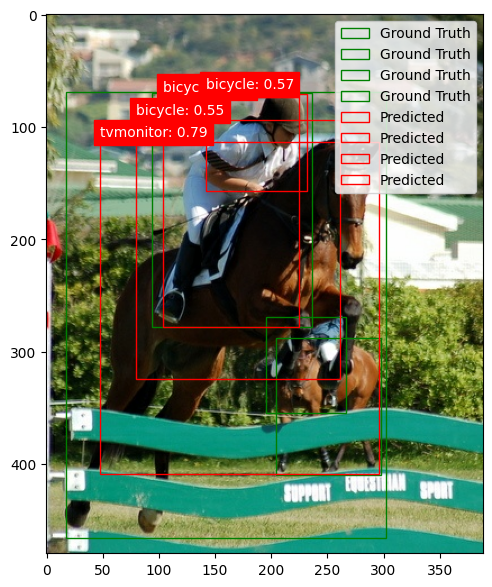

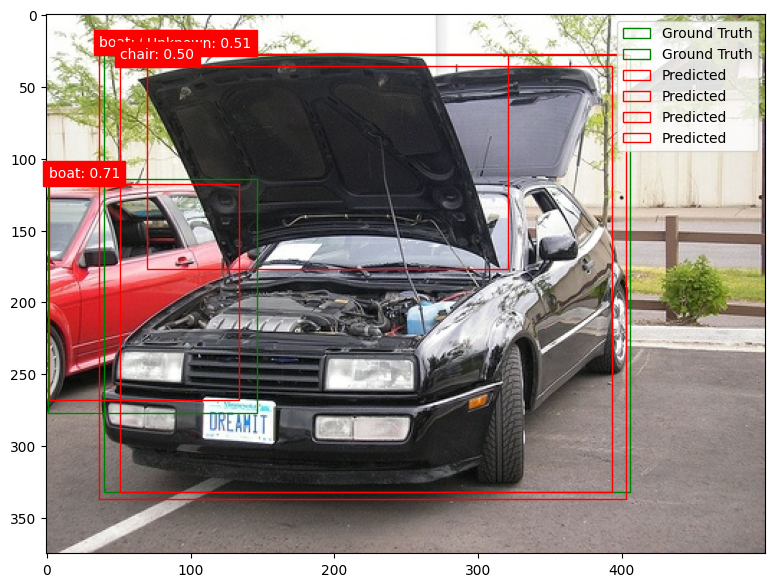

In [ ]:
# take a few examples from the training set
for example in train_dataset.take(2):  # Process 2 images
    run_detector_and_visualize(example)



In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the pre-trained YOLOv8 model (e.g., yolov8n for the nano model)
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 33.6MB/s]


In [ ]:
def run_yolov8_and_visualize(image):
    # Convert image to OpenCV format
    image_np = np.array(image)

    # Run YOLOv8 detection
    results = model.predict(image_np, verbose=False)  # Run YOLOv8 detection

    # Visualize image
    plt.figure(figsize=(10, 7))
    plt.imshow(image_np)

    # Draw predicted boxes
    for box in results[0].boxes:  # Iterate over detected boxes
        xmin, ymin, xmax, ymax = map(int, box.xyxy[0].tolist())  # Bounding box coordinates
        confidence = box.conf[0]  # Confidence score
        class_id = int(box.cls[0])  # Class ID

        # Get class name
        label = model.names[class_id] if class_id in model.names else "Unknown"

        # Draw the bounding box and label
        plt.gca().add_patch(
            patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor="red",
                facecolor="none"
            )
        )
        plt.text(
            xmin,
            ymin - 5,
            f"{label}: {confidence:.2f}",
            color="white",
            backgroundcolor="red",
            fontsize=8
        )

    plt.show()



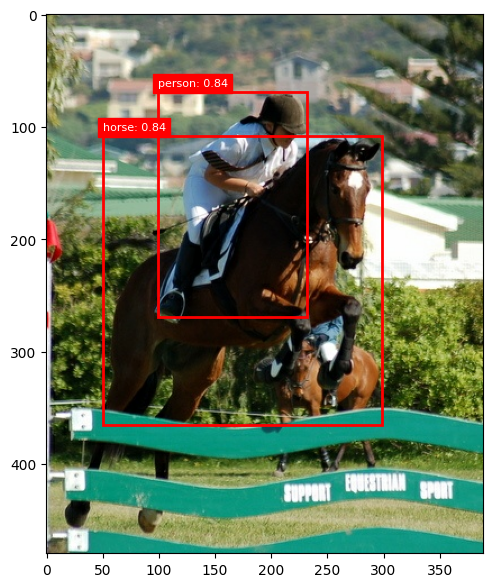

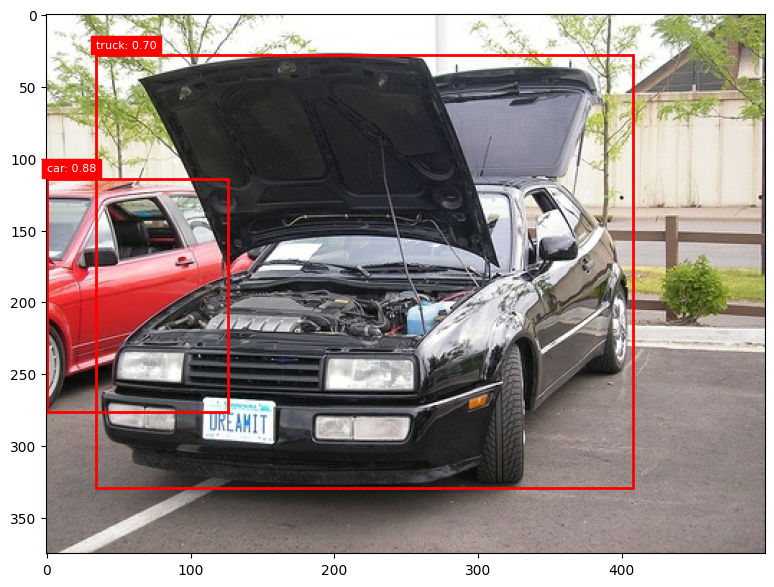

In [ ]:
for example in train_dataset.take(2):
    image = example["image"]
    run_yolov8_and_visualize(image)